In [1]:
from __future__ import print_function

import sys
sys.path.append("/Users/abhishekkadian/Documents/Github/jaa-dl/assignment-1")
sys.path.append("/Users/abhishekkadian/Documents/Github/jaa-dl/assignment-1/ladder/ladder-ak/")

import numpy as np
import pickle

import torch
from torch.autograd import Variable
from torch.optim import Adam

from ladder import Ladder
from encoder import StackedEncoders
from decoder import StackedDecoders

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
batch_size = 32
noise_std = 0.5
epochs = 10

encoder_in = 28 * 28
decoder_in = 10
encoder_sizes = [1000, 500, 250, 250, 250, decoder_in]
decoder_sizes = [250, 250, 250, 500, 1000, encoder_in]
unsupervised_costs_lambda = [0.1, 0.1, 0.1, 0.1, 0.1, 20., 2000.]

encoder_activations = ["relu", "relu", "relu", "relu", "relu", "softmax"]
encoder_train_bn_scaling = [False, False, False, False, False, True]
encoder_bias = [False, False, False, False, False, False]

ladder = Ladder(encoder_in, encoder_sizes, decoder_in, decoder_sizes, encoder_in,
                encoder_activations, encoder_train_bn_scaling, encoder_bias, noise_std)

optimizer = Adam(ladder.parameters(), lr=0.002)
loss_labelled = torch.nn.CrossEntropyLoss()
loss_unsupervised = [torch.nn.MSELoss() for i in range(len(decoder_sizes) + 1)]

In [3]:
with open("data/train_labeled.p") as f:
    train_dataset = pickle.load(f)
with open("data/validation.p") as f:
    valid_dataset = pickle.load(f)
    
loader_kwargs = {}
    
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **loader_kwargs)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded
3000
750


In [53]:
with open("data/train_unlabeled.p") as f:
    unlabeled_dataset = pickle.load(f)
unlabeled_dataset.train_labels = torch.LongTensor([-1 for x in range(unlabeled_dataset.train_data.size()[0])])
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, **loader_kwargs)

In [56]:
for x, (data, labels) in enumerate(unlabeled_loader):
    print(data)
    break


(0 ,0 ,.,.) = 
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
           ...             ⋱             ...          
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
     ⋮ 

(1 ,0 ,.,.) = 
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
           ...             ⋱             ...          
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
     ⋮ 

(2 ,0 ,.,.) = 
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 -0.4242 -0.4242 -0.4242  ...  -0.4242 -0.4242 -0.4242
 

In [80]:
temp_dataset = torch.FloatTensor([[1, 2], [3, 4], [4, 5]])

In [81]:
temp_loader = torch.utils.data.DataLoader(temp_dataset, batch_size=1, shuffle=True)


 4  5
[torch.FloatTensor of size 1x2]

In [22]:
count = 0

In [24]:
while True:
    train_loader.__iter__().__next__()
    count += batch_size
    print(count, train_loader.__iter__().samples_remaining)

77824 3000
77856 3000
77888 3000
77920 3000
77952 3000
77984 3000
78016 3000
78048 3000
78080 3000
78112 3000
78144 3000
78176 3000
78208 3000
78240 3000
78272 3000
78304 3000
78336 3000
78368 3000
78400 3000
78432 3000
78464 3000
78496 3000
78528 3000
78560 3000
78592 3000
78624 3000
78656 3000
78688 3000
78720 3000
78752 3000
78784 3000
78816 3000
78848 3000
78880 3000
78912 3000
78944 3000
78976 3000
79008 3000
79040 3000
79072 3000
79104 3000
79136 3000
79168 3000
79200 3000
79232 3000
79264 3000
79296 3000
79328 3000
79360 3000
79392 3000
79424 3000
79456 3000
79488 3000
79520 3000
79552 3000
79584 3000
79616 3000
79648 3000
79680 3000
79712 3000
79744 3000
79776 3000
79808 3000
79840 3000
79872 3000
79904 3000
79936 3000
79968 3000
80000 3000
80032 3000
80064 3000
80096 3000
80128 3000
80160 3000
80192 3000
80224 3000
80256 3000
80288 3000
80320 3000
80352 3000
80384 3000
80416 3000
80448 3000
80480 3000
80512 3000
80544 3000
80576 3000
80608 3000
80640 3000
80672 3000
80704 3000

KeyboardInterrupt: 

In [4]:
for e in range(epochs):
    agg_cost = 0.
    agg_supervised_cost = 0.
    agg_unsupervised_cost = 0.
    num_batches = 0

    # Training
    ladder.train()

    # TODO: Add volatile for the input parameters in training and validation

    for batch_idx, (data, target) in enumerate(train_loader):
        # pass through encoders
        data = data[:,0,:,:].numpy()
        data = data.reshape(data.shape[0], 28 * 28)
        data = torch.FloatTensor(data)
        # TODO: Hold off on this, things should work right now because LongTensor is only used for cost.
        # TODO: Change from LongTensor to FloatTensor. Autograd has a bug with LongTensor.
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()

        # do a noisy pass
        output_noise = ladder.forward_encoders_noise(data)
        tilde_z_layers = ladder.get_encoders_tilde_z(reverse=True)

        # do a clean pass
        output_clean = ladder.forward_encoders_clean(data)
        z_pre_layers = ladder.get_encoders_z_pre(reverse=True)
        z_layers = ladder.get_encoders_z(reverse=True)

        tilde_z_bottom = ladder.get_encoder_tilde_z_bottom()

        # pass through decoders
        hat_z_layers = ladder.forward_decoders(tilde_z_layers, output_noise, tilde_z_bottom)

        z_pre_layers.append(data)
        z_layers.append(data)

        # TODO: Verify if you have to batch-normalize the bottom-most layer also
        # batch normalize using mean, var of z_pre
        bn_hat_z_layers = ladder.decoder_bn_hat_z_layers(hat_z_layers, z_pre_layers)

        # calculate costs
        cost_supervised = loss_labelled.forward(output_noise, target)
        cost_unsupervised = 0.
        assert (len(loss_unsupervised) == len(z_layers) and
                len(z_layers) == len(bn_hat_z_layers) and
                len(loss_unsupervised) == len(unsupervised_costs_lambda))
        for cost_lambda, loss, z, bn_hat_z in zip(unsupervised_costs_lambda, loss_unsupervised, z_layers, bn_hat_z_layers):
            c = cost_lambda * loss.forward(bn_hat_z, z)
            cost_unsupervised += c

        # backprop
        cost = cost_supervised + cost_unsupervised
        cost.backward()

        agg_cost += cost.data[0]
        agg_supervised_cost += cost_supervised.data[0]
        agg_unsupervised_cost += cost_unsupervised.data[0]
        optimizer.step()
        num_batches += 1

    # Evaluation
    ladder.eval()

    agg_cost /= num_batches
    agg_supervised_cost /= num_batches
    agg_unsupervised_cost /= num_batches
    correct = 0.
    total = 0.
    for batch_idx, (data, target) in enumerate(valid_loader):
        data = data[:, 0, :, :].numpy()
        data = data.reshape(data.shape[0], 28 * 28)
        data = torch.FloatTensor(data)
        data, target = Variable(data), Variable(target)
        output = ladder.forward_encoders_clean(data)
        output = output.data.numpy()
        preds = np.argmax(output, axis=1)
        target = target.data.numpy()
        correct += np.sum(target == preds)
        total += target.shape[0]

    print("epoch", e + 1,
          "total cost:", "{:.4f}".format(agg_cost),
          "supervised cost:", "{:.4f}".format(agg_supervised_cost),
          "unsupervised cost:", "{:.4f}".format(agg_unsupervised_cost),
          "validation accuracy:", correct / total)
    print("")

print("=====================\n")

print("Done :)")

epoch 1 total cost: 1126.6530 supervised cost: 2.0253 unsupervised cost: 1124.6276 validation accuracy: 0.8354

epoch 2 total cost: 344.0144 supervised cost: 1.8742 unsupervised cost: 342.1402 validation accuracy: 0.8522

epoch 3 total cost: 201.0664 supervised cost: 1.8236 unsupervised cost: 199.2429 validation accuracy: 0.8847

epoch 4 total cost: 170.5182 supervised cost: 1.7836 unsupervised cost: 168.7345 validation accuracy: 0.8697

epoch 5 total cost: 161.4770 supervised cost: 1.7643 unsupervised cost: 159.7127 validation accuracy: 0.8904

epoch 6 total cost: 157.7134 supervised cost: 1.7456 unsupervised cost: 155.9678 validation accuracy: 0.9004

epoch 7 total cost: 153.8359 supervised cost: 1.7163 unsupervised cost: 152.1196 validation accuracy: 0.906

epoch 8 total cost: 151.6162 supervised cost: 1.7000 unsupervised cost: 149.9162 validation accuracy: 0.906

epoch 9 total cost: 150.3651 supervised cost: 1.7022 unsupervised cost: 148.6629 validation accuracy: 0.9137

epoch 10 t

In [5]:
original_image = []
reconstructed_bottom = []

In [6]:
for batch_idx, (data, target) in enumerate(valid_loader):
    data = data[:, 0, :, :].numpy()
    data = data.reshape(data.shape[0], 28 * 28)
    data = torch.FloatTensor(data)
    data, target = Variable(data, volatile=True), Variable(target)
    output_noise = ladder.forward_encoders_noise(data)
    tilde_z_layers = ladder.get_encoders_tilde_z(reverse=True)
    
    # do a noisy pass
    output_noise = ladder.forward_encoders_noise(data)
    tilde_z_layers = ladder.get_encoders_tilde_z(reverse=True)

    # do a clean pass
    output_clean = ladder.forward_encoders_clean(data)
    z_pre_layers = ladder.get_encoders_z_pre(reverse=True)
    z_layers = ladder.get_encoders_z(reverse=True)

    tilde_z_bottom = ladder.get_encoder_tilde_z_bottom()

    # pass through decoders
    hat_z_layers = ladder.forward_decoders(tilde_z_layers, output_noise, tilde_z_bottom)

    z_pre_layers.append(data)
    z_layers.append(data)
    
    original_image.append(data.clone())
    reconstructed_bottom.append(hat_z_layers[-1].clone())

    # TODO: Verify if you have to batch-normalize the bottom-most layer also
    # batch normalize using mean, var of z_pre
    bn_hat_z_layers = ladder.decoder_bn_hat_z_layers(hat_z_layers, z_pre_layers)
    
    if batch_idx == 1:
        break

In [7]:
ind = 1

In [8]:
temp = original_image[0][ind].data.numpy()

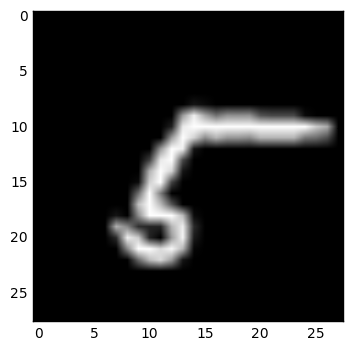

In [9]:
plt.imshow(temp.reshape(28, 28), cmap='gray')

In [10]:
temp2 = reconstructed_bottom[0][ind].data.numpy()

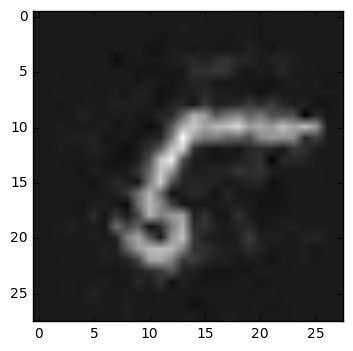

In [11]:
plt.imshow(temp2.reshape(28, 28), cmap='gray')